## FDW Crop Production Data Profiling - Niger

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('./data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32631'
fn_shapes = sorted(glob.glob('./data/shapefile/fewsnet/NE_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#read in username and password
exec(open('/Users/wanders7/Documents/Code/Logins/FDW.py').read())
auth = (username, password)
parameters = {
    'format': 'json',
    'country': 'Niger',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   |
| 1972	 | NE1972A1 | 7	| NE1972A2	| 35	|
| 1992	 | NE1992A1 | 8	| NE1992A2	| 36	|
| 2001	 | NE2001A1 | 8	| NE2001A2	| 37	|
| 2012	 | NE2012A1 | 8	| NE2012A2	| 74	|
| 2018	 | NE2018A1 | 8	| NE2018A2	| 67	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([NE_Admin2_1972,NE_Admin2_1992,NE_Admin2_2001,NE_Admin2_2012,NE_Admin2_2018], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 12,243
Removed 884 "Missing Value" points
3,811/3,837 "Area Planted" points are retained.
3,774/3,837 "Quantity Produced" points are retained.
3,774/3,837 "Yield" points are retained.
0/732 "Area Harvested" points are retained.
Current data points: 11,359

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1980 - 2021
5 grain types are found: Fonio, Maize (Corn), Millet, Rice (Paddy), Sorghum
1 seasons are found: Main season (06-01)
1 crop production system are found: none
Data sources include:
[1] Ministere de l'Agriculture, Niger --- FEWS NET Agro Maps, Niger
[2] Ministere de l'Agriculture, Niger --- Official agricultural statistics, Niger
[3] Ministere de l'Agriculture, Niger --- Resultats definitifs campagne agricole, Niger
Administrative-1 fnids: 0
Administrative-2 fnids: 175
0 reporting units are found: 

- Total production over time -------------

## Niger
Niger crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large/public/seasonal-calendar-niger.png?itok=LFjn6Hxp)

![USDA](https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/wafrica_ng_calendar.png)

- comparison of boundaries
![image](./figures/NE_admin_shapes.png)

- In Niger, basd on the FEWS NET data, there were four times of changes in administrative units: 1972, 1992, 2012, and 2018.

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1972	 | NE1972A1 | 7	| NE1972A2	| 35	|
| 1992	 | NE1992A1 | 8	| NE1992A2	| 36	|
| 2001	 | NE2001A1 | 8	| NE2001A2	| 37	|
| 2012	 | NE2012A1 | 8	| NE2012A2	| 74	|
| 2018	 | NE2018A1 | 8	| NE2018A2	| 67	|

- The data is all reported in a single main season
- While there is a shapefile for 2018, there is no crop data associated with the 2018 shapefile, so we use 2012 as the most recent shapefile

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = NE_Admin2_2012.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

NE2001A20704:	"Matameye" (FDW) is changed to "Kantche" (shapefile).
NE2012A20311:	"Dioundiou" (FDW) is changed to "Dioudiou" (shapefile).
NE2012A20109:	"Agadez Commune" (FDW) is changed to "Tchirozerine" (shapefile).


In [5]:
# Link admin boundaries ------------------------- #
link_2001, over_2001 = FDW_PD_CreateAdminLink(NE_Admin2_2001, NE_Admin2_2012, 'ADMIN2', 'ADMIN2', prod, epsg)
#assert all(np.unique([v['method'] for k,v in link_2001.items()]) == 'PBR')
link_1992, over_1992 = FDW_PD_CreateAdminLink(NE_Admin2_1992, NE_Admin2_2012, 'ADMIN2', 'ADMIN2', prod, epsg)
#assert all(np.unique([v['method'] for k,v in link_1992.items()]) == 'PBR')
link_1972, over_1972 = FDW_PD_CreateAdminLink(NE_Admin2_1972, NE_Admin2_2012, 'ADMIN2', 'ADMIN2', prod, epsg)
#assert all(np.unique([v['method'] for k,v in link_1972.items()]) == 'PBR')


# Crop specific ratios
link_ratio_1972 = FDW_PD_RatioAdminLink(link_1972, prod, over_1972, mdx_pss)
link_ratio_1992 = FDW_PD_RatioAdminLink(link_1992, prod, over_1992, mdx_pss)
link_ratio_2001 = FDW_PD_RatioAdminLink(link_2001, prod, over_2001, mdx_pss)

# Merge link_ratio
assert link_ratio_1992.keys() == link_ratio_2001.keys()
assert link_ratio_1972.keys() == link_ratio_2001.keys()

link_merged = [link_ratio_1972, link_ratio_1992, link_ratio_2001]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'NE2001A20103' as no record found in: ['NE2012A20103']
CBR is considered for 'NE2001A20203' as no record found in: ['NE2012A20209']
CBR is considered for 'NE2001A20702' as no record found in: ['NE2012A20707']
CBR is considered for 'NE1992A20103' as no record found in: ['NE2012A20103']
CBR is considered for 'NE1992A20203' as no record found in: ['NE2012A20209']
CBR is considered for 'NE1992A20702' as no record found in: ['NE2012A20707']
CBR is considered for 'NE1972A20702' as no record found in: ['NE2012A20707']
CBR is considered for 'NE1972A20203' as no record found in: ['NE2012A20209']
CBR is considered for 'NE1972A20103' as no record found in: ['NE2012A20103']


In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
#I need to be able to look at the source docs here. I think maize planted area was used
#area_new.loc[2019,pd.IndexSlice['NE2012A20804',:,'Millet','Main season',:,:,'none']] = 2000
#area_new.loc[2019,pd.IndexSlice['NE2012A20805',:,'Millet','Main season',:,:,'none']] = 4000

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "growing year"
cols = ['season_name','product','crop_production_system','growing_month','harvest_year','harvest_month','growing_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','growing_year','growing_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #

# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #

# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)
# Calibration of Growing and Harvest year and season
cs = {
    'Main season': {'growing_month':{'06-01':'06-01'},'harvest_month':{'12-01':'10-01'}},
}
cy = {}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# # ----------------------------------------------- #

# Save data
save_hdf('./data/crop/adm_crop_production_NE.hdf', stack)
save_hdf('./data/crop/adm_crop_production_NE_raw.hdf', df)
save_npz('./data/crop/adm_crop_production_NE_ratio.npz', link_ratio)

./data/crop/adm_crop_production_NE.hdf is saved.
./data/crop/adm_crop_production_NE_raw.hdf is saved.
./data/crop/adm_crop_production_NE_ratio.npz is saved.


In [7]:
stack_gscd

fnid country country_code admin_1       admin_2          name  \
0      NE2012A20104   Niger           NE  Agadez  Tchirozerine  Tchirozerine   
1      NE2012A20104   Niger           NE  Agadez  Tchirozerine  Tchirozerine   
2      NE2012A20104   Niger           NE  Agadez  Tchirozerine  Tchirozerine   
3      NE2012A20104   Niger           NE  Agadez  Tchirozerine  Tchirozerine   
4      NE2012A20104   Niger           NE  Agadez  Tchirozerine  Tchirozerine   
...             ...     ...          ...     ...           ...           ...   
18527  NE2012A20107   Niger           NE  Agadez     Iferouane     Iferouane   
18528  NE2012A20107   Niger           NE  Agadez     Iferouane     Iferouane   
18529  NE2012A20107   Niger           NE  Agadez     Iferouane     Iferouane   
18530  NE2012A20107   Niger           NE  Agadez     Iferouane     Iferouane   
18531  NE2012A20107   Niger           NE  Agadez     Iferouane     Iferouane   

            product  season_name  growing_year growing_month  harvest_year  \
0           Sorghum  Main season          1985         06-01          1985   
1           Sorghum  Main season          1985         06-01          1985   
2           Sorghum  Main season          1985         06-01          1985   
3           Sorghum  Main season          1986         06-01          1986   
4           Sorghum  Main season          1986         06-01          1986   
...             ...          ...           ...           ...           ...   
18527  Maize (Corn)  Main season          2015         06-01          2015   
18528  Maize (Corn)  Main season          2015         06-01          2015   
18529  Maize (Corn)  Main season          2019         06-01          2019   
18530  Maize (Corn)  Main season          2019         06-01          2019   
18531  Maize (Corn)  Main season          2019         06-01          2019   

      harvest_month crop_production_system   indicator      value   gscd_code  
0             12-01                   none        area   9.724373  calibrated  
1             12-01                   none  production   9.724373  calibrated  
2             12-01                   none       yield   1.000000  calibrated  
3             12-01                   none        area  10.534738  calibrated  
4             12-01                   none  production  10.534738  calibrated  
...             ...                    ...         ...        ...         ...  
18527         12-01                   none  production  43.000000  calibrated  
18528         12-01                   none       yield   1.000000  calibrated  
18529         10-01                   none        area  78.000000  calibrated  
18530         10-01                   none  production  71.000000  calibrated  
18531         10-01                   none       yield   0.910256  calibrated  

[18532 rows x 16 columns]

## Visualization of production data

./figures/NE_bar_natgrainprod_Main season.png is saved.


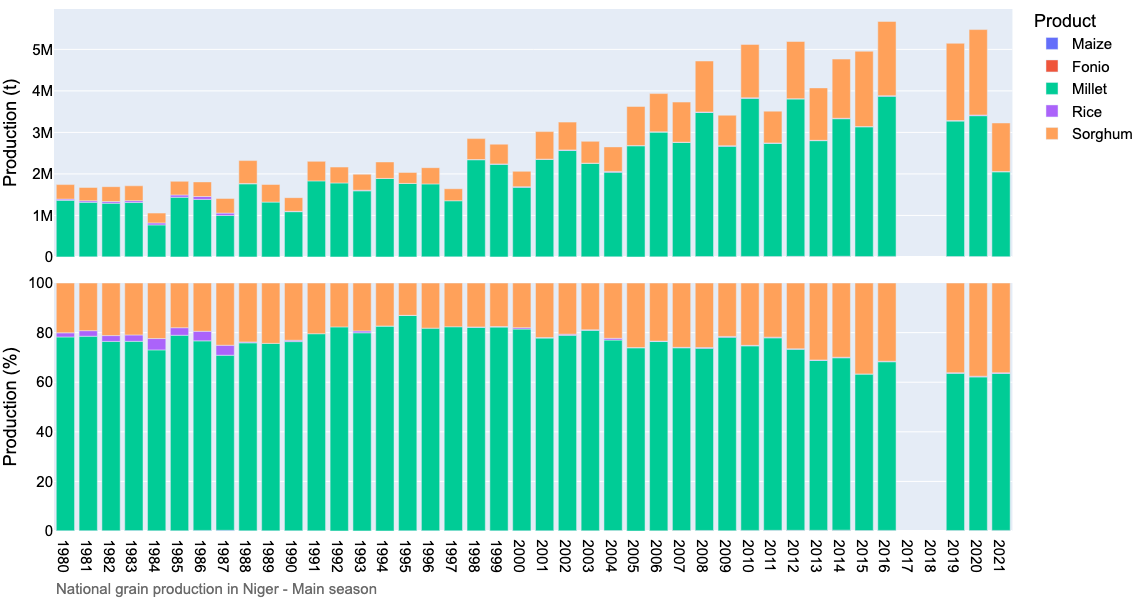

In [8]:
# Bar chart of national grain production
country_iso, country_name = 'NE', 'Niger'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize', 'Fonio','Millet', 'Rice','Sorghum']
for season_name in ['Main season']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = './figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()

./figures/NE_line_pay_Millet_Main season.png is saved.


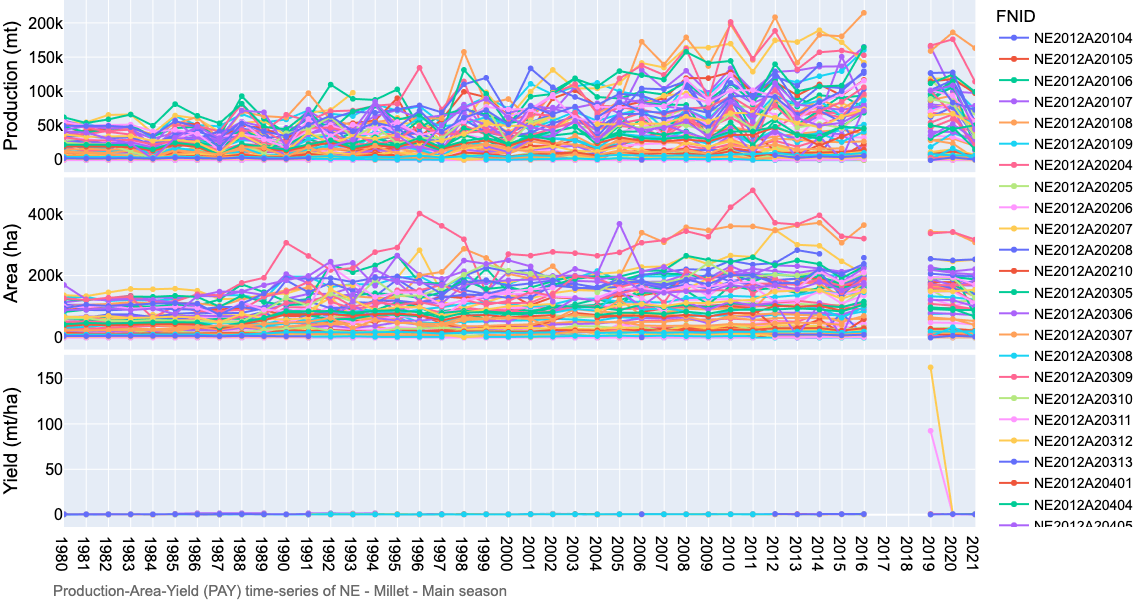

./figures/NE_line_pay_Sorghum_Main season.png is saved.


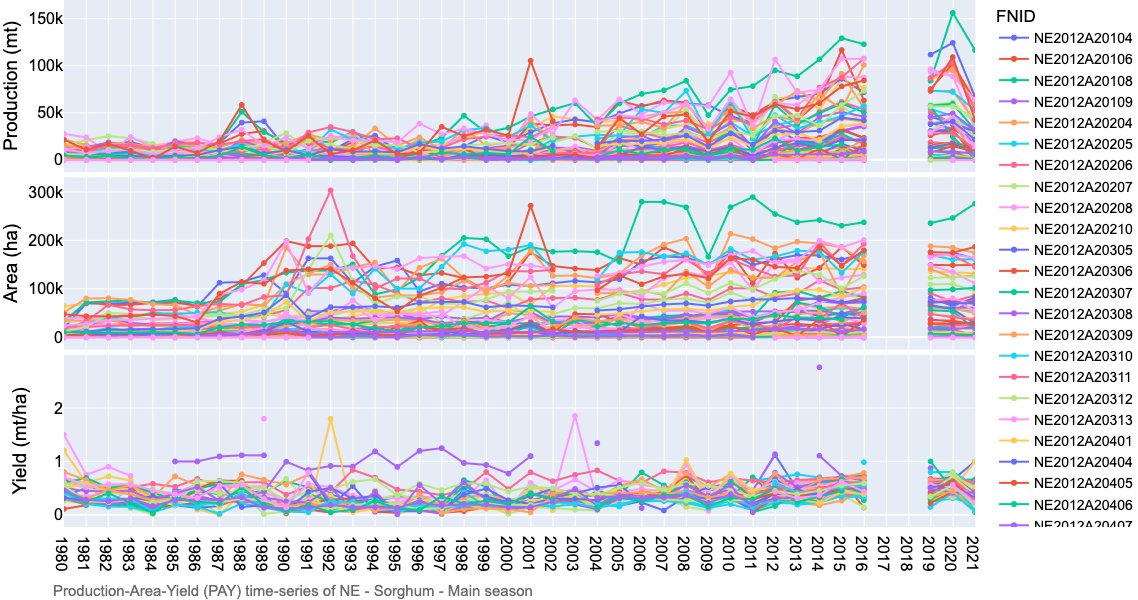

./figures/NE_line_pay_Maize_Main season.png is saved.


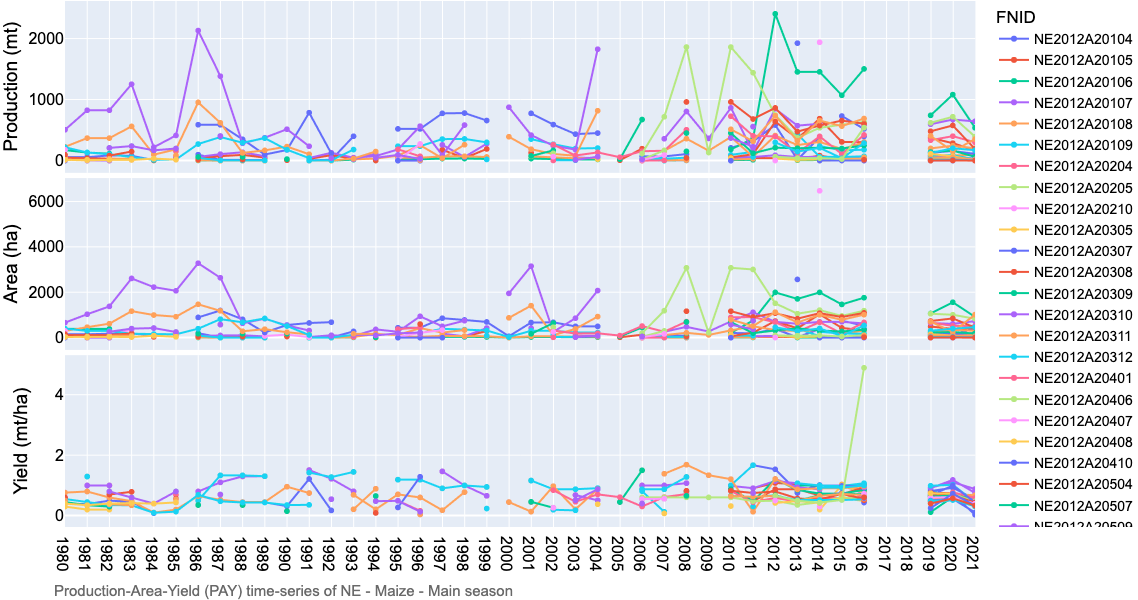

./figures/NE_line_pay_Rice_Main season.png is saved.


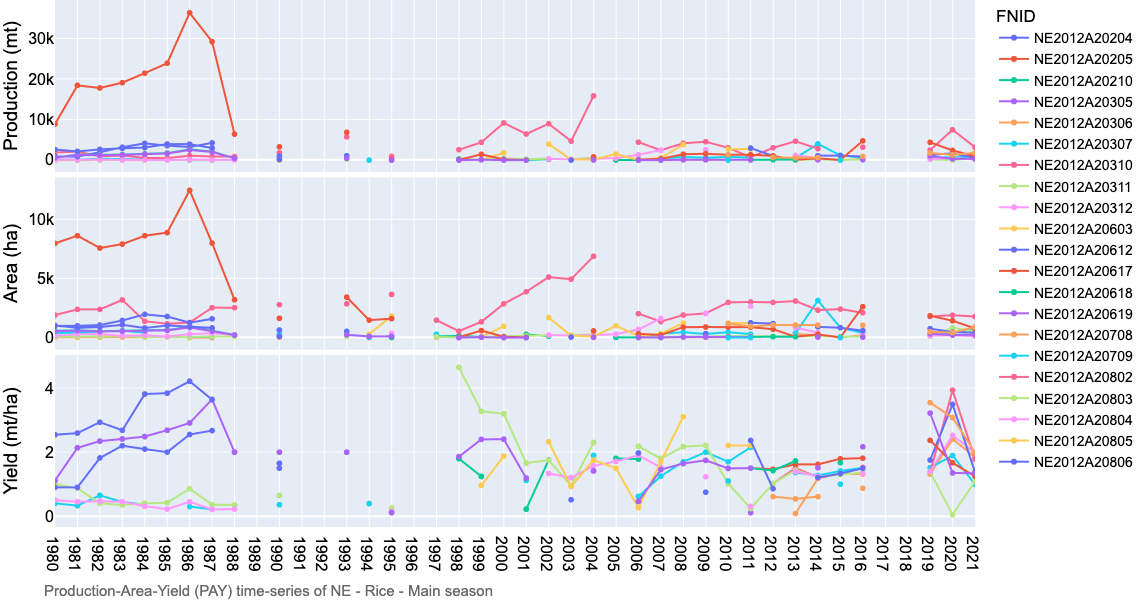

./figures/NE_line_pay_Fonio_Main season.png is saved.


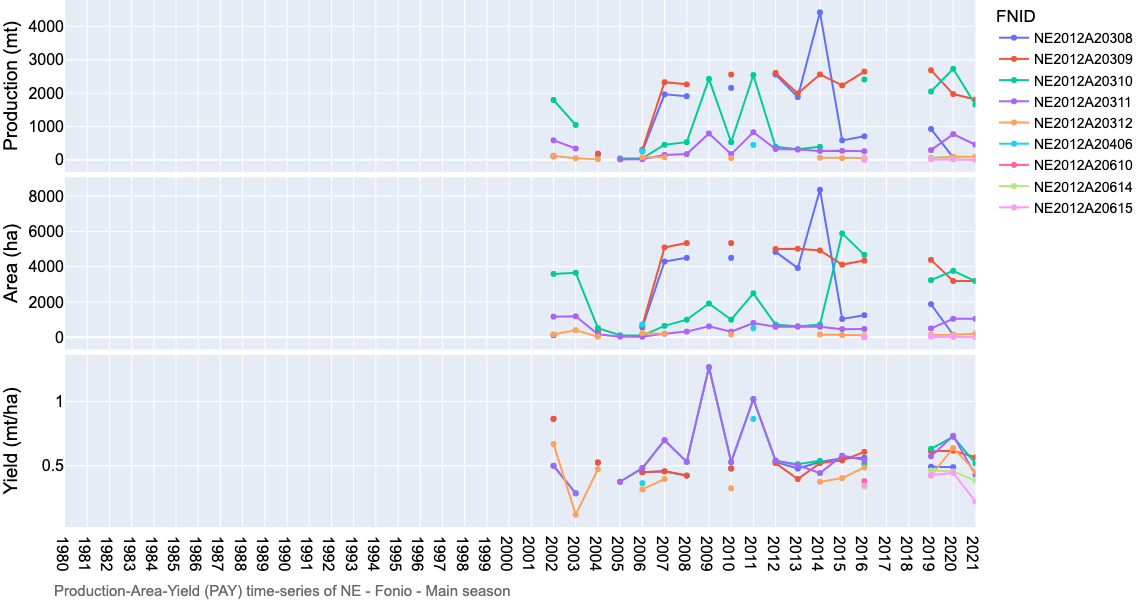

In [9]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'NE', 'Niger'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Millet','Main season'],
    ['Sorghum','Main season'],
    ['Maize','Main season'],
    ['Rice','Main season'],
    ['Fonio','Main season'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = './figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()

In [10]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'NE', 'Niger'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('./data/crop/adm_crop_production_%s_ratio.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
product_season = [
    ['Millet','Main season'],
    ['Sorghum','Main season'],
    ['Maize','Main season'],
    ['Rice','Main season'],
    ['Fonio','Main season'],
]
for product_name, season_name in product_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = './figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)

./figures/crop_calibrated/NE_Millet_Main season_NE2012A20104.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20106.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20108.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20109.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20305.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20306.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20307.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20308.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20309.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20310.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20311.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20312.png is saved.
./figures/crop_calibrated/NE_Millet_Main season_NE2012A20313.png is saved.
./figures/crop_calibrated

In [11]:
# Heatmap of seasonal data availability
country_iso, country_name = 'NE', 'Niger'
df = pd.read_hdf('./data/crop/adm_crop_production_%s_raw.hdf' % country_iso)
df['year'] = df['harvest_year']
code = {'Main season':1}
comb = {1:1,10:2,11:3}
comb_name = {1:'Main season'}
for product_name in ['Sorghum','Millet','Maize (Corn)']:
    fig = plt.figure()
    data = df[(df['product'] == product_name) & (df['season_name'].isin(code.keys()))]
    footnote = 'Seasonal data availability in %s - %s (uncorrected)' % (country_name, product_name)
    fn_save = './figures/%s_heat_seasondata_%s.png' % (country_iso, product_name)
    plt = PlotHeatSeasonData(data, code, comb, comb_name, footnote, fn_save)

NameError: name 'plt' is not defined